In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

def generate_mock_data(n_samples=1000):
    data = {
        'age': np.random.randint(18, 65, n_samples),
        'education_years': np.random.randint(0, 20, n_samples),
        'experience': np.random.randint(0, 30, n_samples),
        'skills_score': np.random.randint(1, 11, n_samples),
        'rural_urban': np.random.choice(['Rural', 'Urban'], n_samples),
        'gender': np.random.choice(['Male', 'Female'], n_samples),
        'industry': np.random.choice(['Agriculture', 'Manufacturing', 'Services', 'Technology'], n_samples),
        'gdp_growth': np.random.uniform(1, 5, n_samples),
        'unemployment_rate': np.zeros(n_samples)
    }
    
    df = pd.DataFrame(data)
    
    df['unemployment_rate'] = (
        20 - 0.2 * df['education_years'] 
        - 0.1 * df['experience'] 
        - 0.5 * df['skills_score']
        + 5 * (df['rural_urban'] == 'Rural')
        + 2 * (df['gender'] == 'Female')
        - 0.5 * df['gdp_growth']
        + np.random.normal(0, 2, n_samples)
    )
    
    df['unemployment_rate'] = np.clip(df['unemployment_rate'], 0, 100)
    
    return df

In [3]:
# Data Exploration and Visualization
def explore_and_visualize(df):
    # Separate numeric and categorical columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    categorical_cols = df.select_dtypes(exclude=[np.number]).columns

    print(df.describe())
    
    print("\nCorrelation Matrix (Numeric Features):")
    correlation_matrix = df[numeric_cols].corr()
    print(correlation_matrix['unemployment_rate'].sort_values(ascending=False))
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title("Correlation Heatmap (Numeric Features)")
    plt.tight_layout()
    plt.show()
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    sns.scatterplot(data=df, x='education_years', y='unemployment_rate', ax=axes[0, 0])
    sns.boxplot(data=df, x='industry', y='unemployment_rate', ax=axes[0, 1])
    sns.violinplot(data=df, x='rural_urban', y='unemployment_rate', ax=axes[1, 0])
    sns.regplot(data=df, x='gdp_growth', y='unemployment_rate', ax=axes[1, 1])
    plt.tight_layout()
    plt.show()

    # Additional visualizations for categorical variables
    for cat_col in categorical_cols:
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, x=cat_col)
        plt.title(f"Distribution of {cat_col}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 6))
        sns.boxplot(data=df, x=cat_col, y='unemployment_rate')
        plt.title(f"{cat_col} vs Unemployment Rate")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


In [4]:
# Prepare data for modeling
def prepare_data(df):
    X = df.drop('unemployment_rate', axis=1)
    y = df['unemployment_rate']
    
    numeric_features = ['age', 'education_years', 'experience', 'skills_score', 'gdp_growth']
    categorical_features = ['rural_urban', 'gender', 'industry']
    
    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    X_train_preprocessed = preprocessor.fit_transform(X_train)
    X_test_preprocessed = preprocessor.transform(X_test)
    
    numeric_feature_names = numeric_features
    categorical_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist()
    feature_names = numeric_feature_names + categorical_feature_names
    
    return X_train_preprocessed, X_test_preprocessed, y_train, y_test, feature_names

In [5]:
# Train and evaluate model
def train_and_evaluate_model(X_train, X_test, y_train, y_test):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R-squared Score: {r2:.2f}")
    
    return model

In [6]:
# Analyze feature importance
def analyze_feature_importance(model, feature_names):
    importance = model.feature_importances_
    feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importance})
    feature_importance = feature_importance.sort_values('importance', ascending=False).reset_index(drop=True)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
    plt.title("Top 10 Feature Importances")
    plt.tight_layout()
    plt.show()
    
    return feature_importance

In [7]:
# Partial Dependence Plots
def plot_partial_dependence(model, X_train, feature_names, feature_importance):
    # Get the indices of the top 3 important features
    top_features_indices = feature_importance['feature'].index[:3].tolist()
    
    fig, ax = plt.subplots(figsize=(12, 4))
    display = PartialDependenceDisplay.from_estimator(
        model, X_train, features=top_features_indices, 
        feature_names=feature_names, ax=ax
    )
    plt.tight_layout()
    plt.show()

              age  education_years   experience  skills_score   gdp_growth  \
count  5000.00000      5000.000000  5000.000000   5000.000000  5000.000000   
mean     41.16820         9.670000    14.616800      5.473000     3.012360   
std      13.53105         5.736557     8.588406      2.882383     1.155557   
min      18.00000         0.000000     0.000000      1.000000     1.000806   
25%      29.00000         5.000000     7.000000      3.000000     2.021193   
50%      41.00000        10.000000    15.000000      5.000000     3.006162   
75%      53.00000        15.000000    22.000000      8.000000     4.015506   
max      64.00000        19.000000    29.000000     10.000000     4.999564   

       unemployment_rate  
count        5000.000000  
mean           15.867356  
std             4.021992  
min             4.396446  
25%            12.880064  
50%            15.864819  
75%            18.842315  
max            28.453687  

Correlation Matrix (Numeric Features):
unemployment_r

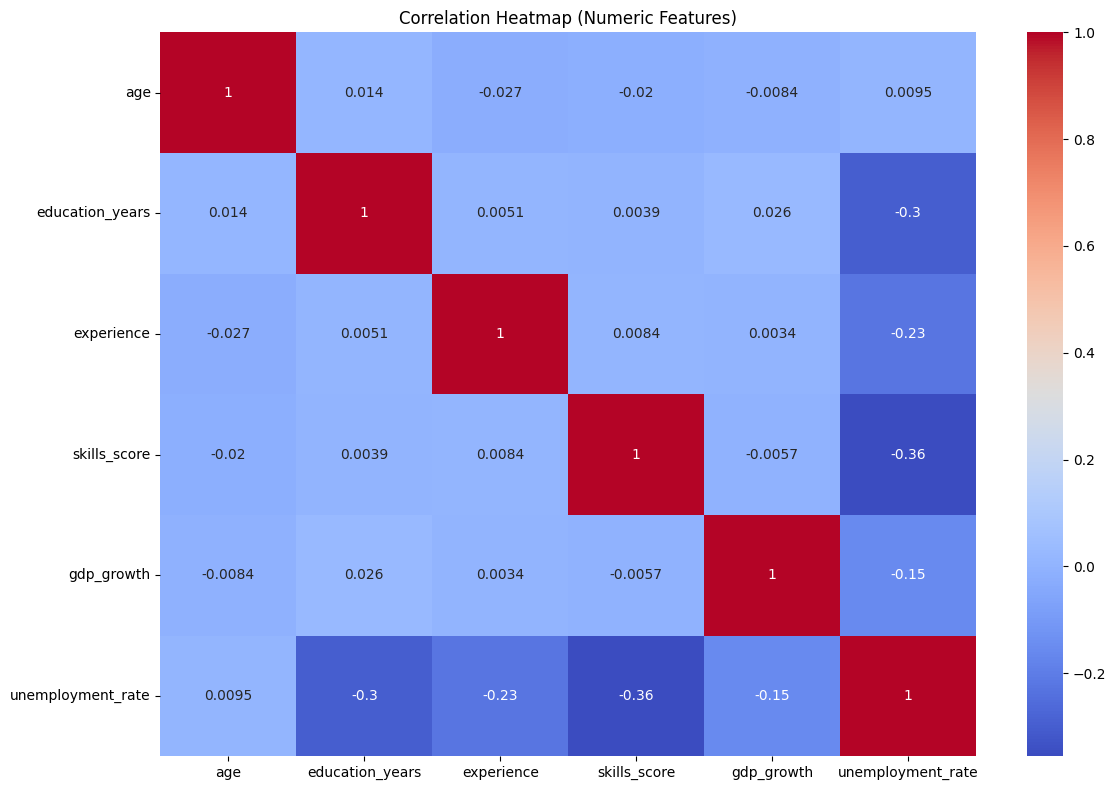

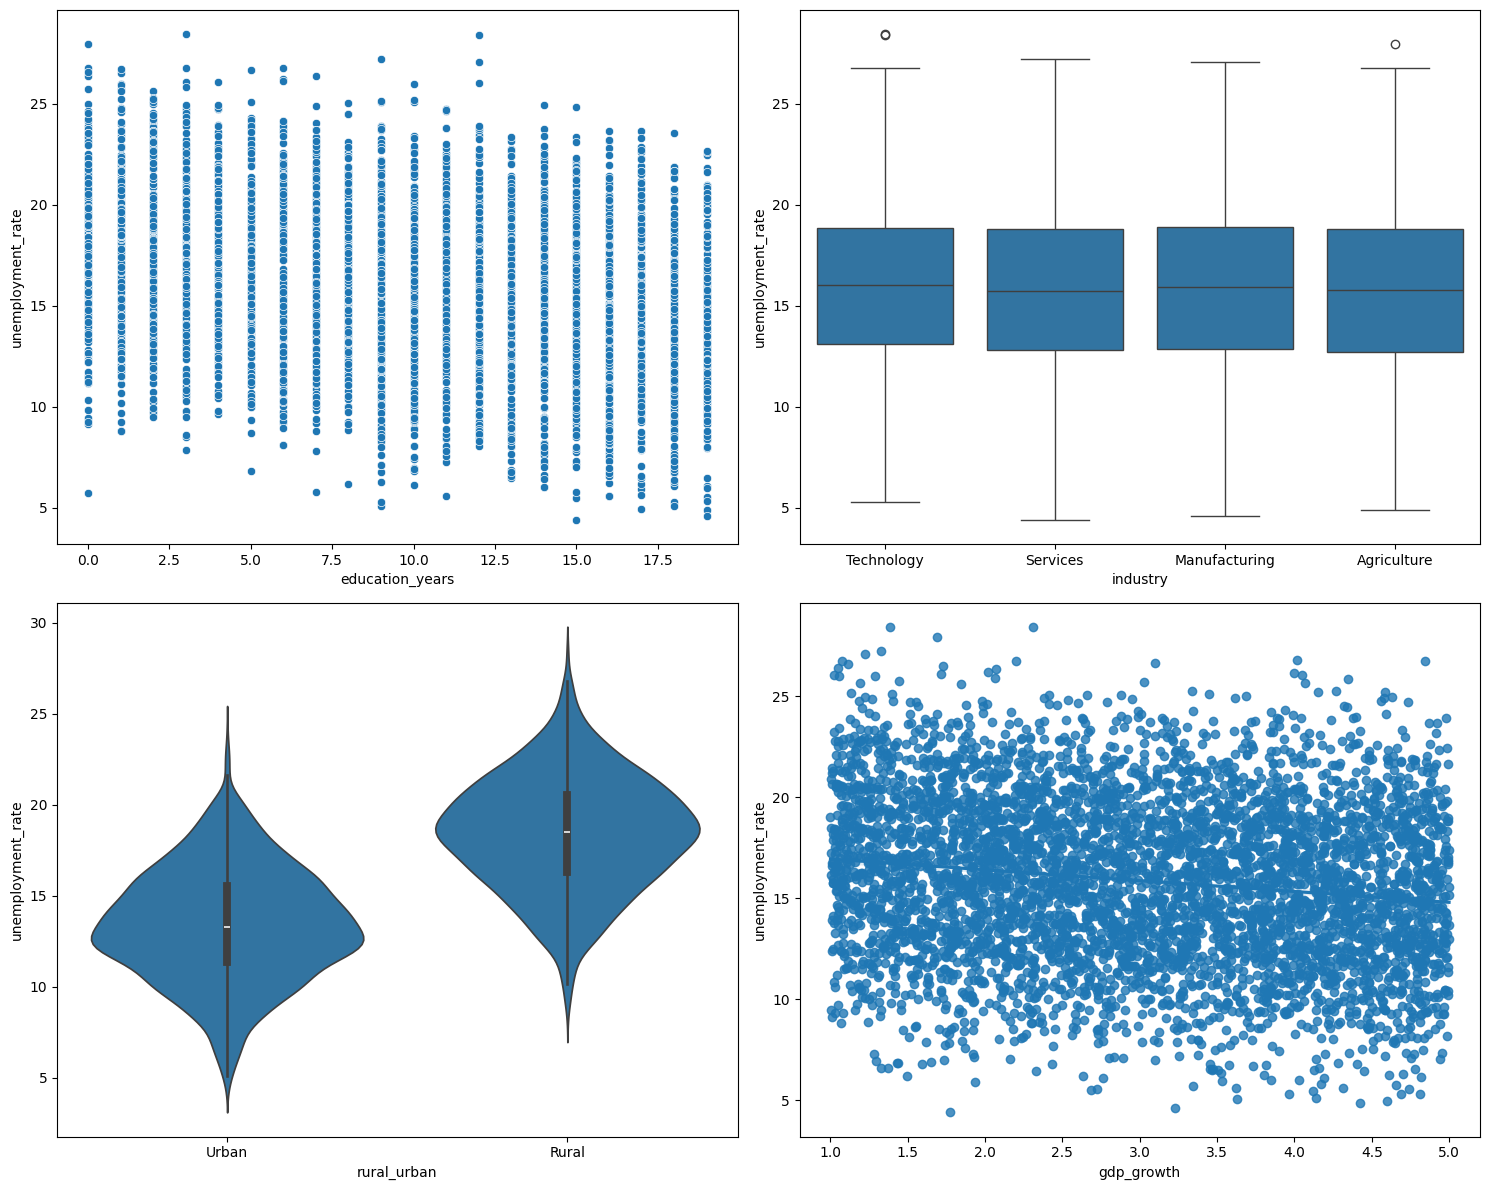

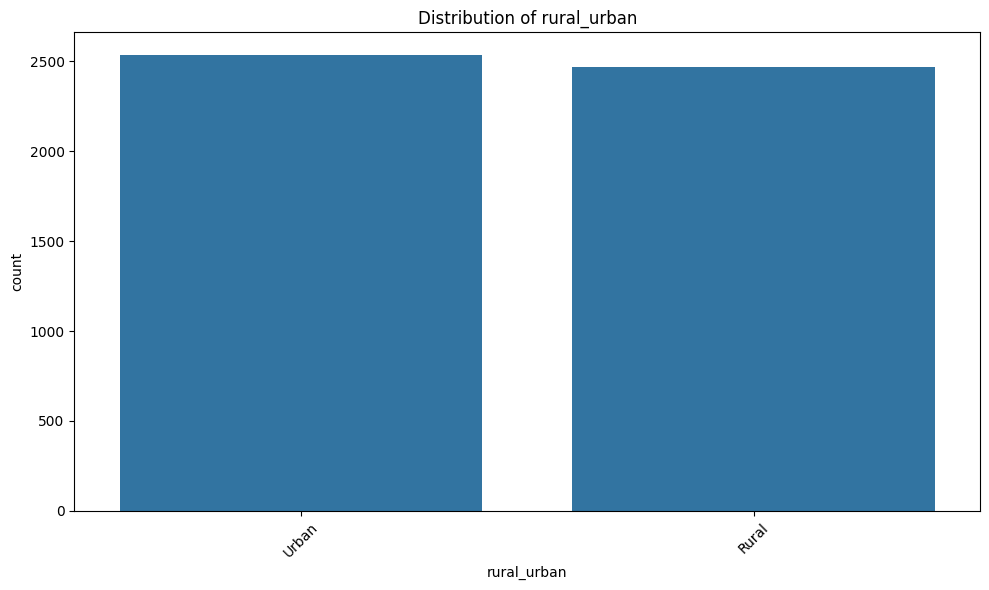

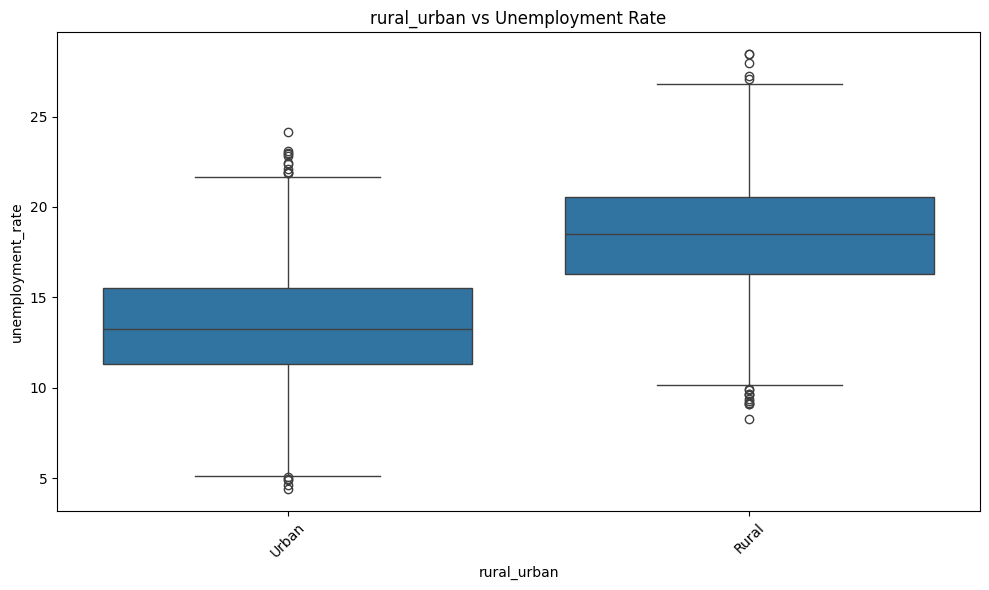

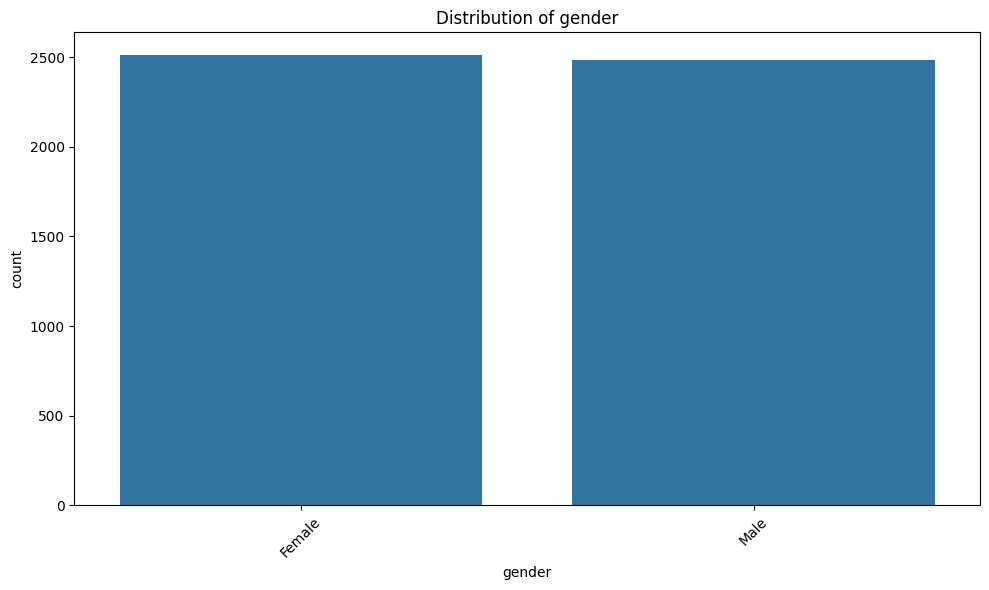

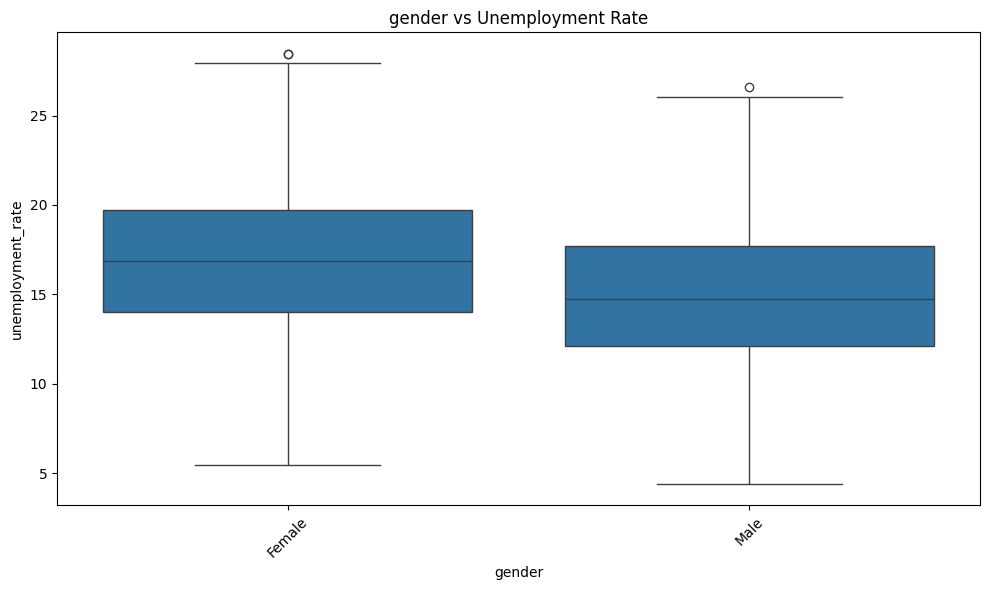

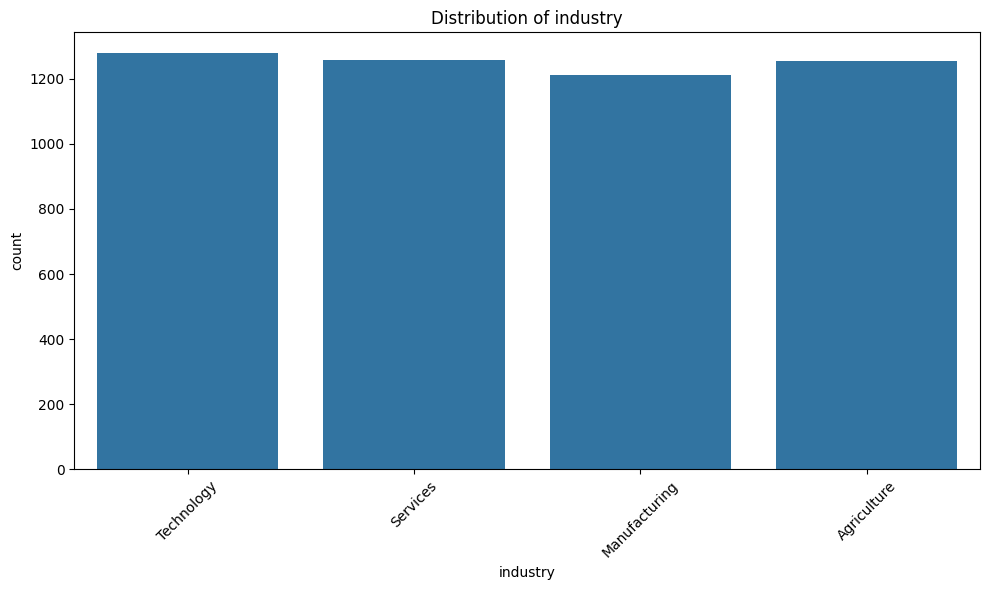

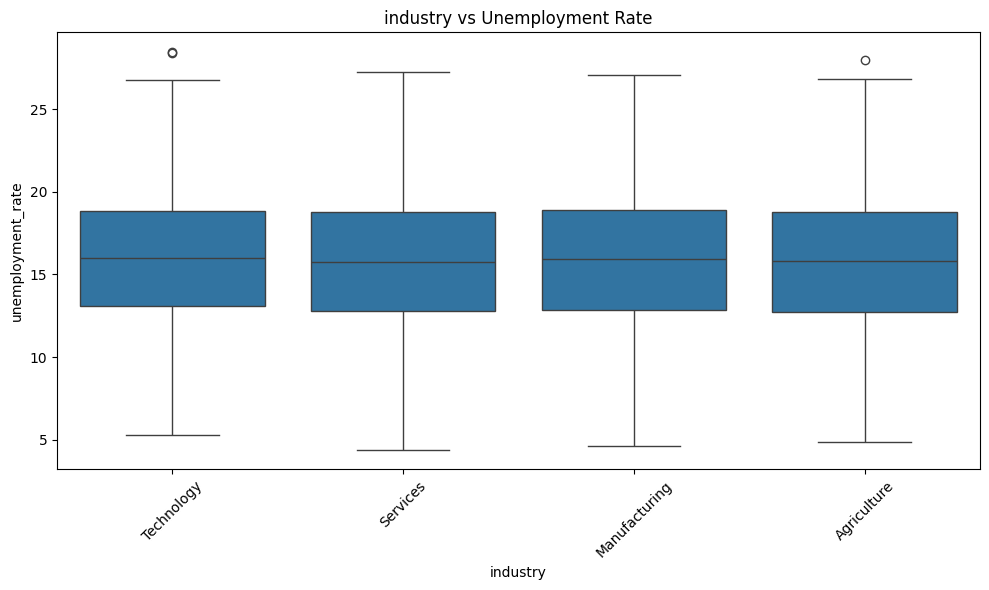

Mean Squared Error: 4.69
R-squared Score: 0.71


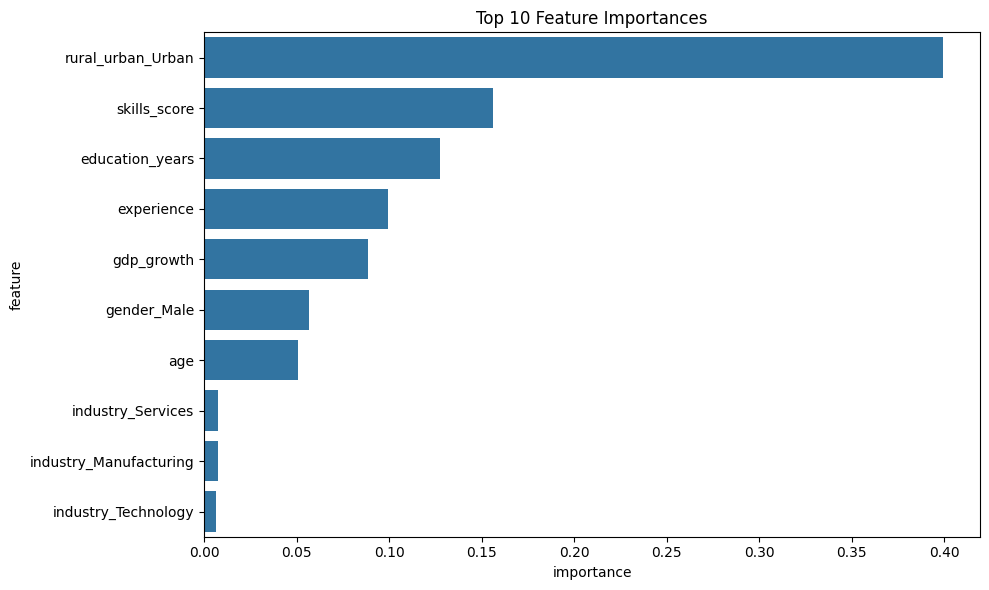

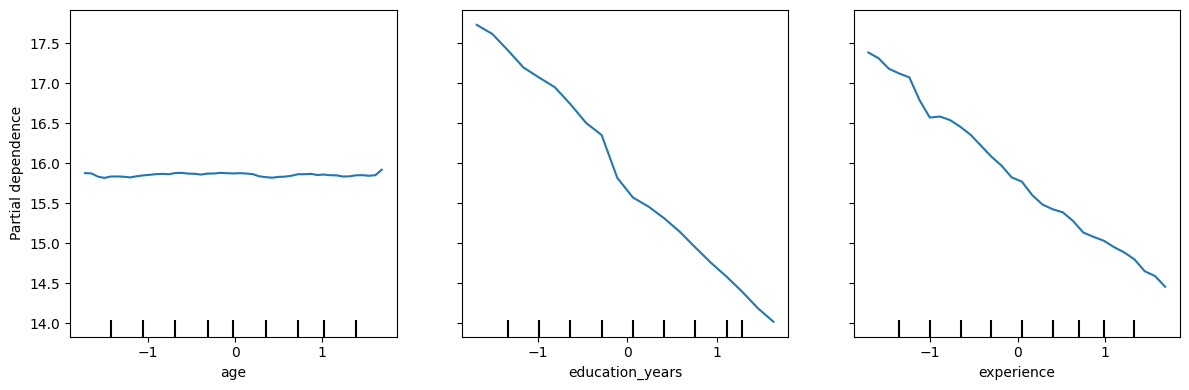


Key Insights and Recommendations:
1. Education and skills development are crucial for reducing unemployment.
2. Focus on bridging the urban-rural divide in employment opportunities.
3. Promote policies that encourage GDP growth to create more job opportunities.
4. Address gender disparities in the job market.
5. Invest in high-growth industries like technology and services.

Analysis of rural_urban:
rural_urban
Rural    18.428063
Urban    13.375365
Name: unemployment_rate, dtype: float64

Analysis of gender:
gender
Female    16.852094
Male      14.872323
Name: unemployment_rate, dtype: float64

Analysis of industry:
industry
Technology       16.005729
Services         15.880513
Manufacturing    15.867346
Agriculture      15.713033
Name: unemployment_rate, dtype: float64


In [8]:
# Main function
def main():
    # Generate and explore data
    df = generate_mock_data(5000)
    explore_and_visualize(df)
    
    # Prepare data and train model
    X_train, X_test, y_train, y_test, feature_names = prepare_data(df)
    model = train_and_evaluate_model(X_train, X_test, y_train, y_test)
    
    # Analyze feature importance
    feature_importance = analyze_feature_importance(model, feature_names)
    
    # Plot partial dependence
    plot_partial_dependence(model, X_train, feature_names, feature_importance)
    
    # Generate insights and recommendations
    print("\nKey Insights and Recommendations:")
    print("1. Education and skills development are crucial for reducing unemployment.")
    print("2. Focus on bridging the urban-rural divide in employment opportunities.")
    print("3. Promote policies that encourage GDP growth to create more job opportunities.")
    print("4. Address gender disparities in the job market.")
    print("5. Invest in high-growth industries like technology and services.")

    # Additional analysis for categorical variables
    categorical_cols = df.select_dtypes(exclude=[np.number]).columns
    for cat_col in categorical_cols:
        print(f"\nAnalysis of {cat_col}:")
        print(df.groupby(cat_col)['unemployment_rate'].mean().sort_values(ascending=False))

if __name__ == "__main__":
    main()